

1.   Run this first to mount drive, then cd to appropriate folder.


In [1]:
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)

In [ ]:
#%cd /content/drive/MyDrive/EEE199/Thesis

/content/drive/.shortcut-targets-by-id/1y9XYxPPSA_BuwrgEldj9-q_4xdMkiPui/Thesis


In [2]:
import os
import sys
sys.path.append("..")

2. Preprocess database, edit location in main

In [3]:
import numpy as np
import pandas as pd
import re
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    precision_score, recall_score, classification_report,
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,  make_scorer
)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import metrics
import pickle
from collections import Counter
import warnings
from sklearn.utils import resample
import os
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from python import FL_server

# Suppress all warnings from scikit-learn
warnings.filterwarnings("ignore")

#Print for Debug
debug = "Baygon"


In [4]:
#IMPORT ALL DATA FILES FOR CLIENTS

client1_train_data = np.load('clients_data/client1_train_inputs_new.npy')
client2_train_data = np.load('clients_data/client2_train_inputs_new.npy')
client3_train_data = np.load('clients_data/client3_train_inputs_new.npy')
client1_test_data = np.load('clients_data/client1_test_inputs_new.npy')
client2_test_data = np.load('clients_data/client2_test_inputs_new.npy')
client3_test_data = np.load('clients_data/client3_test_inputs_new.npy')

client1_train_labels = pd.read_csv('clients_data/client1_train_labels_new.csv')
client2_train_labels = pd.read_csv('clients_data/client2_train_labels_new.csv')
client3_train_labels = pd.read_csv('clients_data/client3_train_labels_new.csv')
client1_test_labels = pd.read_csv('clients_data/client1_test_labels_new.csv')
client2_test_labels = pd.read_csv('clients_data/client2_test_labels_new.csv')
client3_test_labels = pd.read_csv('clients_data/client3_test_labels_new.csv')

trainset = [client1_train_labels,client2_train_labels,client3_train_labels]
testset = [client1_test_labels,client2_test_labels,client3_test_labels]

for count in range(len(trainset)):
  series = trainset[count]
  indx = series.index
  index = [series.iloc[i, 0] for i in range(0,len(indx))]
  vals = [series.iloc[i, 1] for i in range(0,len(indx))]
  trainset[count]= pd.Series(vals, index)

for count in range(len(testset)):
  series = testset[count]
  indx = series.index
  index = [series.iloc[i, 0] for i in range(0,len(indx))]
  vals = [series.iloc[i, 1] for i in range(0,len(indx))]
  testset[count]= pd.Series(vals, index)

In [5]:
# MODEL TRAINING

def client_training(data, label, model, batch_size):
    # Separate majority and minority classes
    majority_samples = data[label == 0]
    minority_samples = data[label == 1]

    # Determine the number of samples in the majority and minority classes
    num_minority_samples = len(minority_samples)
    num_majority_samples = len(majority_samples)

    # Determine the number of batches needed for balancing based on majority samples
    num_batches = int(np.ceil(num_majority_samples / batch_size))

    balanced_data = []
    balanced_labels = []

    # Iterate over each batch
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_majority_samples)

        # Select a subset of majority samples for the current batch
        majority_batch = majority_samples[start_idx:end_idx]

        # Randomly sample minority samples for the current batch
        minority_batch = minority_samples[np.random.choice(num_minority_samples, size=end_idx - start_idx, replace=True)]

        # Combine the majority and minority samples
        batch_data = np.concatenate((majority_batch, minority_batch))
        batch_labels = np.concatenate((np.zeros(len(majority_batch)), np.ones(len(minority_batch))))

        # Shuffle the batch data and labels
        batch_data, batch_labels = shuffle(batch_data, batch_labels)

        balanced_data.append(batch_data)
        balanced_labels.append(batch_labels)

    balanced_data = np.vstack(balanced_data)
    balanced_labels = np.concatenate(balanced_labels)

    # Train the model using balanced batches
    model.fit(balanced_data, balanced_labels)

    return model


In [6]:
# MODEL AGGREGATOR

def FedAvg(clients,client_weights,server_model):
    max_num_sv = max([client.support_vectors_.shape[0] for client in clients])
    aggregated_support_vectors = np.zeros((max_num_sv, clients[0].support_vectors_.shape[1]))
    aggregated_labels = np.array([])

    # Aggregate the support vectors and labels based on client weights
    for client, weight in zip(clients, client_weights):
        num_sv = client.support_vectors_.shape[0]
        support_vectors = client.support_vectors_
        labels = client.predict(support_vectors)
        padding = max_num_sv - num_sv
        padded_support_vectors = np.pad(support_vectors, [(0, padding), (0, 0)], mode='constant')
        aggregated_support_vectors += weight * padded_support_vectors
        aggregated_labels = np.concatenate((aggregated_labels, labels))

    aggregated_labels = aggregated_labels[:max_num_sv]

    server_model.fit(aggregated_support_vectors, aggregated_labels)
    return server_model

In [ ]:
# MODEL EVALUATION

def evaluate(model,X_test,y_test,X_train,y_train):

  # Perform predictions and compute scores for the server model
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
  prec = metrics.precision_score(y_test, pred_test)
  recal = metrics.recall_score(y_test, pred_test)
  f1_s = metrics.f1_score(y_test, pred_test)
  train_accuracy = accuracy_score(y_train, pred_train)
  test_accuracy = accuracy_score(y_test, pred_test)

  return prec,recal,f1_s,train_accuracy,test_accuracy



In [ ]:
#CROSS VALIDATION

def validate(model,X_train,y_train):
  # Define the scoring function
  scorer = make_scorer(precision_score, pos_label=1)  # Set pos_label to the minority class label

  # Perform cross-validation with precision as the metric
  cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scorer)

  return cv_scores


In [ ]:
#Training and Evaluation Loop
import time
# Initialize global models
global_model = SVC()
batch_size = 32
epoch = 20
clients = [
    {"train_data": client1_train_data, "train_labels": trainset[0], "test_data": client1_test_data, "test_labels": testset[0], "model": SVC()},
    {"train_data": client2_train_data, "train_labels": trainset[1], "test_data": client2_test_data, "test_labels": testset[1], "model": SVC()},
    {"train_data": client3_train_data, "train_labels": trainset[2], "test_data": client3_test_data, "test_labels": testset[2], "model": SVC()}
]

prev_metrics = {}  # Dictionary to store previous epoch's metrics

for i in range(epoch):
    start_time = time.time()
    for client in clients:
        client_model = client["model"]
        client_model = client_training(client["train_data"], client["train_labels"], client_model, batch_size)

    # Evaluate metrics for the current epoch
    curr_metrics = {}
    for index, client in enumerate(clients):
        client_model = client["model"]
        precision, recall, _, _, _ = evaluate(
            client_model, client["test_data"], client["test_labels"], client["train_data"], client["train_labels"]
        )
        curr_metrics[index] = (precision,recall)
    retrain = [
        index for index, client in enumerate(clients)
        if curr_metrics[index][0] == 0
    ]
    if retrain:
      for index in retrain:
        while curr_metrics[index][0] == 0:
                  clients[index]["model"] = client_training(clients[index]["train_data"], clients[index]["train_labels"], clients[index]["model"], batch_size)
                  precision, recall, _, _, _  = evaluate(clients[index]["model"], clients[index]["test_data"], clients[index]["test_labels"], clients[index]["train_data"], clients[index]["train_labels"])
                  curr_metrics[index] = (precision,recall)

    precisions = [curr_metrics[index][0] for index, client in enumerate(clients)]
    recalls = [curr_metrics[index][0] for index, client in enumerate(clients)]
    total_precision = sum(precisions)
    total_recall = sum(recalls)
    client_weights = [(precision + recall) / (total_precision + total_recall) for precision, recall in zip(precisions, recalls)]

    if i == 0:
        #print(debug)
        global_model = FL_server.FedAvg([client["model"] for client in clients], client_weights,global_model)
        prev_metrics = curr_metrics
    else:
        improved_client_indices = [
            index for index, client in enumerate(clients)
            if (curr_metrics[index][0] > prev_metrics[index][0] or curr_metrics[index][1] > prev_metrics[index][1])
        ]

        if improved_client_indices:
            #print(debug)
            client_models = [clients[index]["model"] for index in improved_client_indices]
            global_model = FL_server.FedAvg(client_models,client_weights,global_model)
            prev_metrics = curr_metrics

    # Update the models of all clients to the global model
    for client in clients:
        client["model"] = global_model


    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Round {i+1} Execution time: {execution_time:.2f} seconds")

# Evaluate and print the final performance metrics
for index, client in enumerate(clients):
    client_model = client["model"]
    precision, recall, f1_score, train_accuracy, test_accuracy = evaluate(
        client_model, client["test_data"], client["test_labels"], client["train_data"], client["train_labels"]
    )
    cv_score = validate(client_model, client["train_data"], client["train_labels"])

    # Print the metrics for the current client
    print()
    print(f"Client {index + 1}:")
    print(f"CV Precision: {cv_score.mean()}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print()


Round 1 Execution time: 142.39 seconds
Round 2 Execution time: 122.03 seconds
Round 3 Execution time: 122.14 seconds
Round 4 Execution time: 106.34 seconds
Round 5 Execution time: 123.27 seconds
Round 6 Execution time: 124.24 seconds
Round 7 Execution time: 107.67 seconds
Round 8 Execution time: 108.98 seconds
Round 9 Execution time: 110.78 seconds
Round 10 Execution time: 108.64 seconds
Round 11 Execution time: 108.87 seconds
Round 12 Execution time: 106.59 seconds
Round 13 Execution time: 109.50 seconds
Round 14 Execution time: 108.16 seconds
Round 15 Execution time: 112.28 seconds
Round 16 Execution time: 109.23 seconds
Round 17 Execution time: 107.58 seconds
Round 18 Execution time: 106.75 seconds
Round 19 Execution time: 106.66 seconds
Round 20 Execution time: 106.22 seconds

Client 1:
CV Precision: 0.9577380952380953
Precision: 1.0
Recall: 0.5921052631578947
F1 Score: 0.743801652892562
Train Accuracy: 0.9598124581379772
Test Accuracy: 0.9516380655226209


Client 2:
CV Precision: 

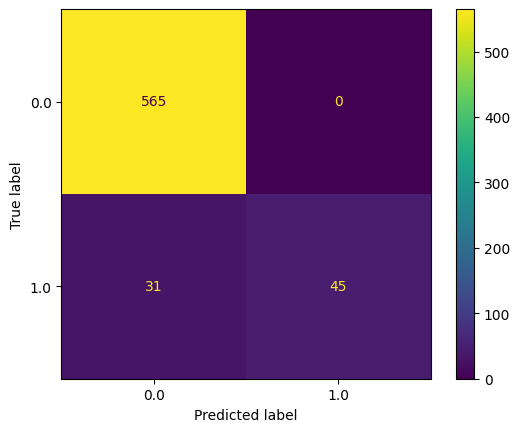

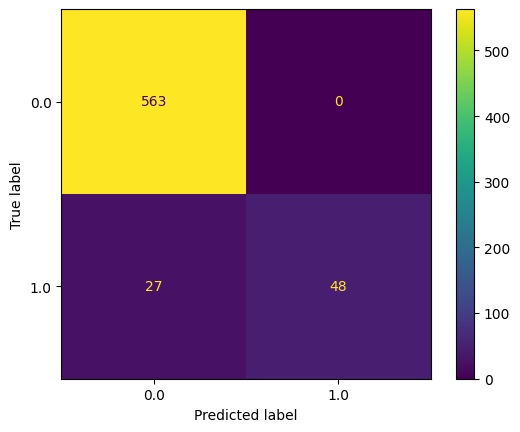

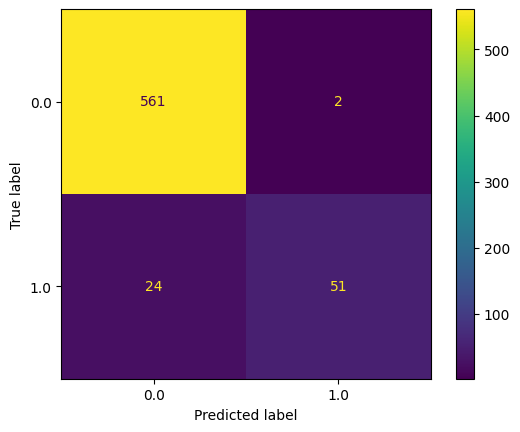

In [ ]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])

for client in clients:
    client_model = client["model"]
    predictions = client_model.predict(client["test_data"])
    cm = confusion_matrix(client["test_labels"], predictions, labels=client_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=client_model.classes_)
    disp.plot()
    plt.show()